In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("..")  # if simulator.ipynb is in /notebooks/

import pickle

from simulation.helpers import create_circular_roads
from simulation.core import System
from simulation.controller import TrafficController
from simulation.data_logger import DataLogger
from simulation.spawners import timed_spawner
from simulation.core import Road, Lane, Car, Obstacle


In [134]:
dt = 0.1
sim_time = 500

system = System(dt=dt, final_time=sim_time)

start_pos = (0, 300)
end_pos = (800, 300)
road = Road(1, 10000, start_pos, end_pos)

system.add_road(road)
road.set_next_road(road)

logger = DataLogger(expected_total_cars=50, tag="basic_one_road_test")
controller = TrafficController(system, logger=logger)

controller.gaussian_spread_car_creator(20, "basic", 0, 0)


In [135]:
for _ in range(int(system.final_time / system.dt)):
    controller.control(system.dt)
    system.update(logger=logger)

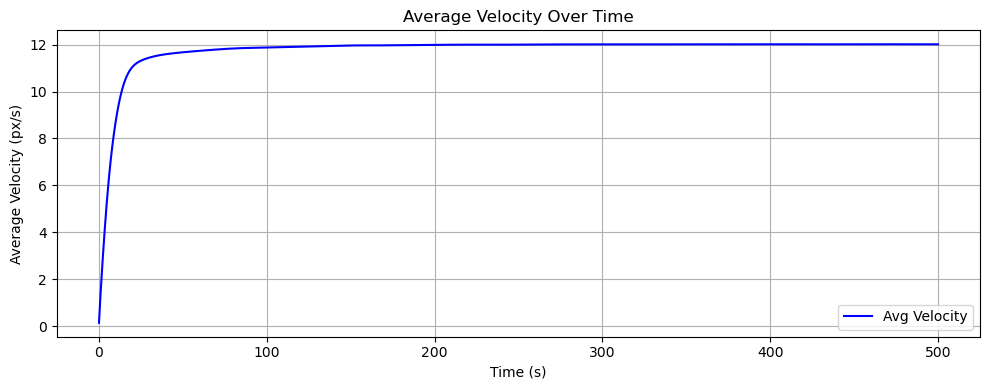

In [136]:
df = logger.to_dataframe()

avg_velocity_by_time = df.groupby("time")["velocity"].mean()

plt.figure(figsize=(10, 4))
plt.plot(avg_velocity_by_time.index, avg_velocity_by_time.values, color='blue', label="Avg Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Average Velocity (px/s)")
plt.title("Average Velocity Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [123]:
def theoretical_velocity(N, L=800, s0=22, T=1.5):
    spacing = L / (N)
    v = (spacing - s0) / T
    return max(0, v)

# Generate analytical curve
x_vals = np.arange(1, 60)
y_theory = [theoretical_velocity(n) for n in x_vals]

In [112]:
# Run loop

avg_velocities = []
for i in range(30):
    
    system = System(dt=dt, final_time=sim_time)

    start_pos = (0, 300)
    end_pos = (800, 300)
    road = Road(1, 10000, start_pos, end_pos)


    system.add_road(road)
    road.set_next_road(road)

    logger = DataLogger(expected_total_cars=50, tag="basic_one_road_test")
    controller = TrafficController(system, logger=logger)

    controller.equal_distance_car_creator(i+1, "basic", 0, 0)

    for _ in range(int(system.final_time / system.dt)):
        controller.control(system.dt)
        system.update(logger=logger)

    df = logger.to_dataframe()
    avg_velocity_by_time = df.groupby("time")["velocity"].mean()
    avg_velocities.append([i+1, avg_velocity_by_time[sim_time-1]])
    print(avg_velocities[-1])

avg_velocities = np.array(avg_velocities)
x = avg_velocities[:, 0]  # car numbers
y = avg_velocities[:, 1]  # average velocities




[1, 424.5176912503463]
[2, 251.32945685953746]
[3, 164.67669769797826]
[4, 119.61448748237338]
[5, 92.58849204197773]
[6, 74.62983947157134]
[7, 61.79938327158832]
[8, 52.212280376951114]
[9, 44.75284276830413]
[10, 38.79224333613921]
[11, 33.91790754247614]
[12, 29.857727902999866]
[13, 26.425113420226143]
[14, 23.482977206998207]
[15, 20.934945734813223]
[16, 18.70494986345166]
[17, 16.73792064200433]
[18, 14.990361437673117]
[19, 13.426717425261836]
[20, 12.019693868873505]
[21, 10.746937448980562]
[22, 9.5900837486021]
[23, 8.534013770490473]
[24, 7.565909908858412]
[25, 6.675532982479933]
[26, 5.853616032446936]
[27, 5.0925733039832535]
[28, 4.386156880068099]
[29, 3.728411354900776]
[30, 3.1145298533755765]


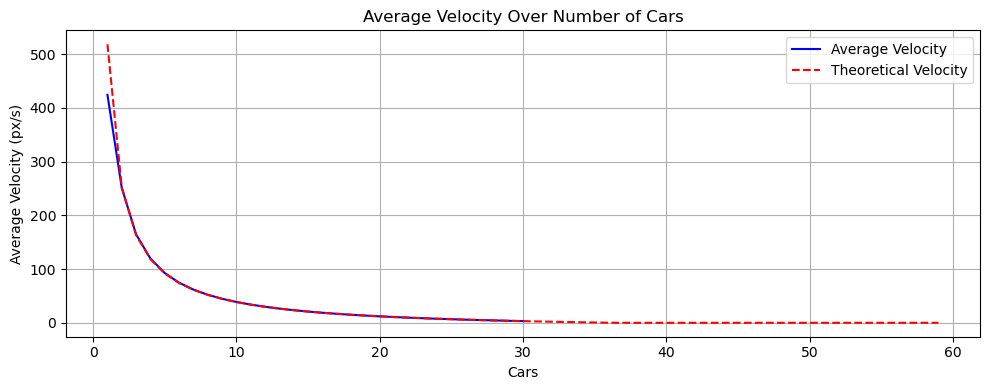

In [124]:
plt.figure(figsize=(10, 4))
plt.plot(x, y, label="Average Velocity", color='blue')
plt.plot(x_vals, y_theory, label="Theoretical Velocity", color='red', linestyle='--')
plt.xlabel("Cars")
plt.ylabel("Average Velocity (px/s)")
plt.title("Average Velocity Over Number of Cars")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
dt = 0.1
sim_time = 500

system = System(dt=dt, final_time=sim_time)

start_pos = (0, 300)
end_pos = (40000, 300)
road = Road(5, 60, start_pos, end_pos)

system.add_road(road)
logger = DataLogger(expected_total_cars=1000, tag="basic_one_road_test")
controller = TrafficController(system, logger=logger)

starting_speed = 30

controller.add_spawn_rule(timed_spawner(1, 0, 200, 0, "random", starting_speed))
controller.add_spawn_rule(timed_spawner(1, 0, 200, 1, "random", starting_speed))
controller.add_spawn_rule(timed_spawner(1, 0, 200, 2, "random", starting_speed))
controller.add_spawn_rule(timed_spawner(1, 0, 200, 3, "random", starting_speed))
controller.add_spawn_rule(timed_spawner(1, 0, 200, 4, "random", starting_speed))

In [53]:
for _ in range(int(system.final_time / system.dt)):
    controller.control(system.dt)
    system.update(logger=logger)

df = logger.to_dataframe()


Inserting car with index:  0 at time: 0.9999999999999999
Inserting car with index:  1 at time: 0.9999999999999999
Inserting car with index:  2 at time: 0.9999999999999999
Inserting car with index:  3 at time: 0.9999999999999999
Inserting car with index:  4 at time: 0.9999999999999999
Inserting car with index:  5 at time: 2.400000000000001
Inserting car with index:  6 at time: 2.400000000000001
Inserting car with index:  7 at time: 2.500000000000001
Inserting car with index:  8 at time: 2.600000000000001
Inserting car with index:  9 at time: 2.700000000000001
Inserting car with index:  10 at time: 3.800000000000002
Inserting car with index:  11 at time: 3.800000000000002
Inserting car with index:  12 at time: 3.900000000000002
Inserting car with index:  13 at time: 4.000000000000002
Inserting car with index:  14 at time: 4.200000000000001
Inserting car with index:  15 at time: 5.299999999999997
Inserting car with index:  16 at time: 5.399999999999997
Inserting car with index:  17 at tim

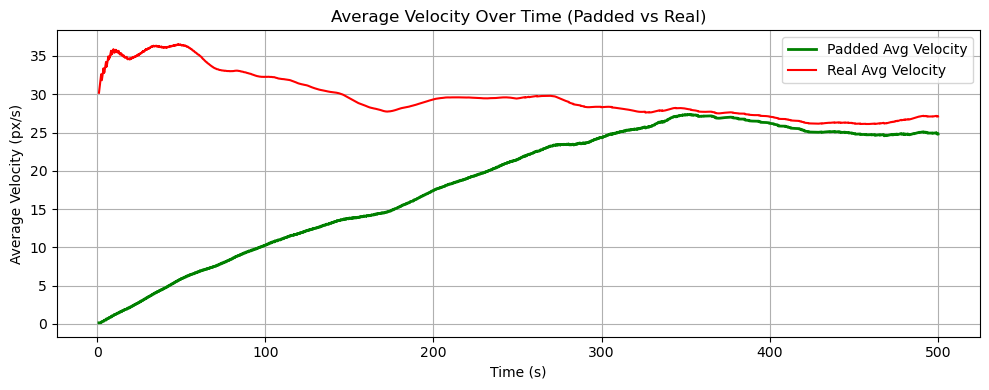

In [54]:
N_total = system.index + 1

plt.figure(figsize=(10, 4))

grouped = df.groupby("time").agg(
    total_velocity=("velocity", "sum"),
    active_cars=("car_id", "nunique")
)

if N_total is not None:
    grouped["padded_avg_velocity"] = grouped["total_velocity"] / N_total
    plt.plot(grouped.index, grouped["padded_avg_velocity"], label="Padded Avg Velocity", color='green', linewidth=2)


grouped["real_avg_velocity"] = grouped["total_velocity"] / grouped["active_cars"]

plt.plot(grouped.index, grouped["real_avg_velocity"], label="Real Avg Velocity", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Average Velocity (px/s)")
plt.title("Average Velocity Over Time (Padded vs Real)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

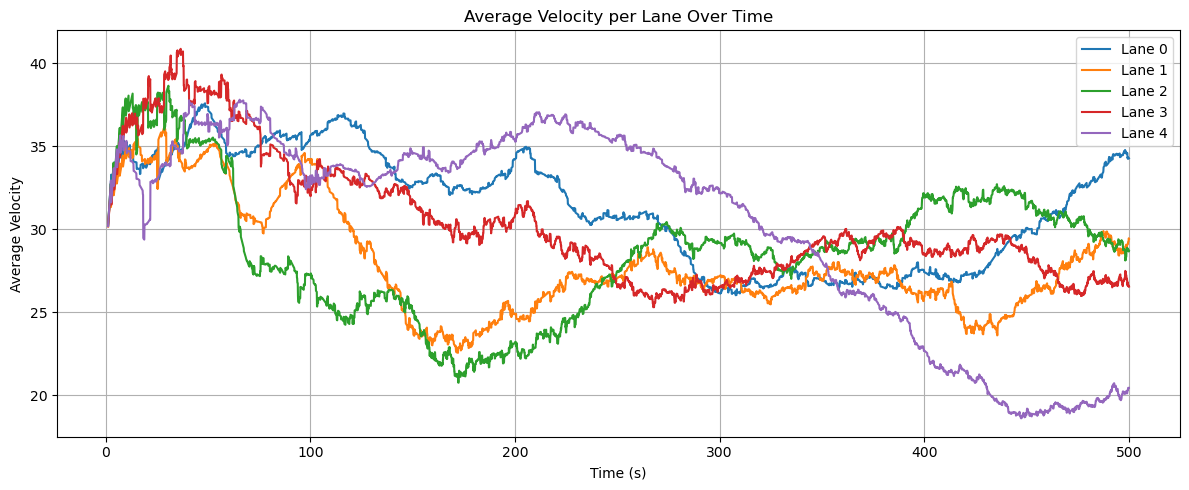

In [55]:
# Group by time and lane, then average velocity
avg_velocity_lane = df.groupby(["time", "lane_id"])["velocity"].mean().unstack()

# Plot each lane
plt.figure(figsize=(12, 5))
for lane in avg_velocity_lane.columns:
    plt.plot(avg_velocity_lane.index, avg_velocity_lane[lane], label=f"Lane {lane}")
plt.xlabel("Time (s)")
plt.ylabel("Average Velocity")
plt.title("Average Velocity per Lane Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


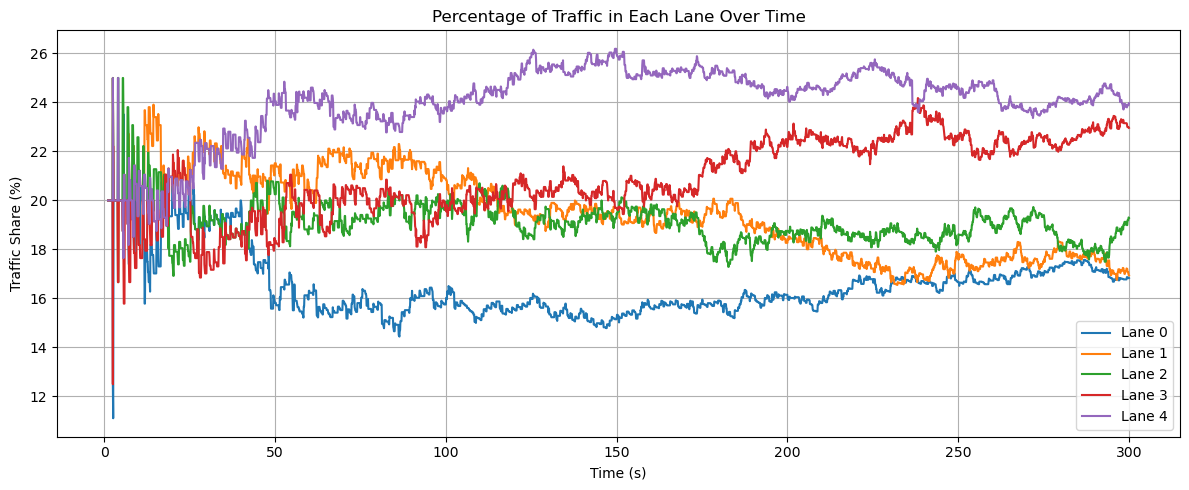

In [41]:
lane_counts = df.groupby(["time", "lane_id"])["car_id"].nunique().unstack()

# Convert to percentage of total cars at each time
lane_percentages = lane_counts.div(lane_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 5))
for lane in lane_percentages.columns:
    plt.plot(lane_percentages.index, lane_percentages[lane], label=f"Lane {lane}")

plt.xlabel("Time (s)")
plt.ylabel("Traffic Share (%)")
plt.title("Percentage of Traffic in Each Lane Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



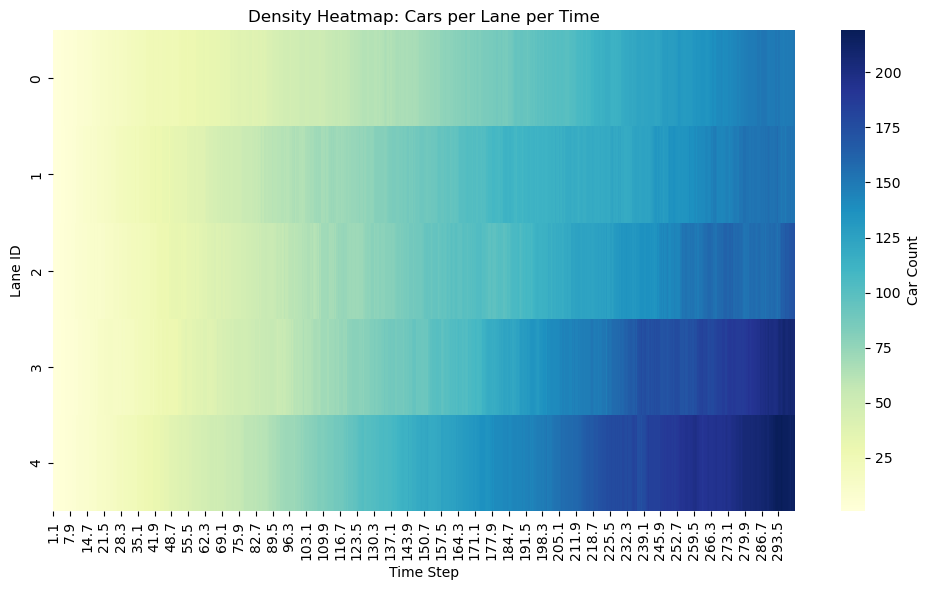

In [42]:
plt.figure(figsize=(10, 6))
sns.heatmap(lane_counts.T, cmap="YlGnBu", cbar_kws={"label": "Car Count"})
plt.title("Density Heatmap: Cars per Lane per Time")
plt.xlabel("Time Step")
plt.ylabel("Lane ID")
plt.tight_layout()
plt.show()


In [32]:
import matplotlib.pyplot as plt

avg_velocities = []
for num in range(4, 50):
    system = System(dt=dt, final_time=sim_time)
    roads = create_circular_roads(10, 1, 300, max_speed=10000)

    for road in roads:
        system.add_road(road)

    logger = DataLogger(tag="basic_one_road_test")
    controller = TrafficController(system, logger=logger)

    controller.equal_distance_car_creator(num)
    # Run loop
    for _ in range(int(system.final_time / system.dt)):
        controller.control(system.dt)
        system.update(logger=logger)

    # Get the full log data
    df = logger.to_dataframe()

    # Group by time and compute average velocity
    avg_velocity_by_time = df.groupby("time")["velocity"].mean()
    avg_velocities.append([num, avg_velocity_by_time[sim_time-1]])
    print(avg_velocities[-1])

# Plot
avg_velocities = np.array(avg_velocities)
x = avg_velocities[:, 0]  # car numbers
y = avg_velocities[:, 1]  # average velocities

plt.figure(figsize=(10, 4))
plt.plot(x, y, label="Average Velocity", color='blue')
plt.xlabel("Cars")
plt.ylabel("Average Velocity (px/s)")
plt.title("Average Velocity Over Number of Cars")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[4, 49.99667605560361]
[5, 49.99667605560361]
[6, 49.99667605560361]
[7, 49.99667605560361]
[8, 49.99667605560361]
[9, 49.99667605560361]
[10, 49.99667605554528]
[11, 49.69889467088763]
[12, 49.344413877664856]
[13, 48.92817114709189]
[14, 48.44831493389843]
[15, 47.893993498038846]
[16, 47.26632654538315]
[17, 46.553939542404585]
[18, 45.7513485292143]
[19, 44.85684050988942]
[20, 43.81523333699041]
[21, 42.79537344497743]
[22, 41.654858021487534]
[23, 40.45012922740223]
[24, 39.19923425519178]
[25, 37.88460997829078]
[26, 36.56241376848358]
[27, 35.20531186953891]
[28, 33.837212553304205]
[29, 32.481238894159986]
[30, 31.026154961330594]
[31, 29.811511322398232]
[32, 28.515176688581253]
[33, 27.280052439913582]
[34, 25.971730015625667]
[35, 24.96132796575871]


KeyboardInterrupt: 